In [1]:
import os
import pandas as pd
import statistics
from pm4py.objects.conversion.log import converter as log_converter
import matplotlib.pyplot as plt

In [2]:
# 1) Load with correct separators & decimals
path = os.path.join(os.getcwd(), "incidentprocess_custom.csv")
data = pd.read_csv(path,
                   sep=";",
                   decimal=",",
                   thousands=".")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303819 entries, 0 to 303818
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Incident ID              303819 non-null  object 
 1   Activity                 303819 non-null  object 
 2   ActivityTimeStamp        303819 non-null  object 
 3   Asset Affected           303819 non-null  object 
 4   Asset Type Affected      303819 non-null  object 
 5   Asset SubType Affected   303819 non-null  object 
 6   Service Affected         303819 non-null  object 
 7   Status                   303819 non-null  object 
 8   Impact                   303819 non-null  int64  
 9   Urgency                  303819 non-null  int64  
 10  Priority                 303819 non-null  int64  
 11  Category                 303819 non-null  object 
 12  Number of Reassignments  303810 non-null  float64
 13  Open Time                303819 non-null  object 
 14  Reop

In [3]:
data.columns = data.columns.str.replace(" ", "_")
data = data.rename(columns={
    "Incident_ID":       "case:concept:name",
    "Activity":          "concept:name",
    "ActivityTimeStamp": "time:timestamp"
})

In [4]:
data.columns

Index(['case:concept:name', 'concept:name', 'time:timestamp', 'Asset_Affected',
       'Asset_Type_Affected', 'Asset_SubType_Affected', 'Service_Affected',
       'Status', 'Impact', 'Urgency', 'Priority', 'Category',
       'Number_of_Reassignments', 'Open_Time', 'Reopen_Time', 'Resolved_Time',
       'Close_Time', 'Handle_Time_(Hours)', 'Closure_Code', 'Asset_Caused',
       'Asset_Type_Caused', 'Asset_SubType_Caused', 'Service_Caused',
       'Assignment_Group'],
      dtype='object')

In [5]:
assert {"case:concept:name","concept:name","time:timestamp"}.issubset(data.columns), \
    "Missing one of the mandatory columns after rename!"

In [6]:
# 3) Parse timestamps once for everything
data["time:timestamp"] = pd.to_datetime(
    data["time:timestamp"],
    infer_datetime_format=True,
    utc=True
)
data["Open_Time"]  = pd.to_datetime(data["Open_Time"],  dayfirst=True)
data["Close_Time"] = pd.to_datetime(data["Close_Time"], dayfirst=True)

C:\Users\sofia\AppData\Local\Temp\ipykernel_16620\172528349.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data["time:timestamp"] = pd.to_datetime(


In [7]:
# 1. Parse your open/close columns (dayfirst=True because your dates are dd/mm/yyyy)
data['Open_Time_dt']  = pd.to_datetime(data['Open_Time'],  dayfirst=True)
data['Close_Time_dt'] = pd.to_datetime(data['Close_Time'], dayfirst=True)

# 2. Compute a fresh handle time in hours
data['computed_handle_hours'] = (
    data['Close_Time_dt'] - data['Open_Time_dt']
).dt.total_seconds() / 3600

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303819 entries, 0 to 303818
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   case:concept:name        303819 non-null  object             
 1   concept:name             303819 non-null  object             
 2   time:timestamp           303819 non-null  datetime64[ns, UTC]
 3   Asset_Affected           303819 non-null  object             
 4   Asset_Type_Affected      303819 non-null  object             
 5   Asset_SubType_Affected   303819 non-null  object             
 6   Service_Affected         303819 non-null  object             
 7   Status                   303819 non-null  object             
 8   Impact                   303819 non-null  int64              
 9   Urgency                  303819 non-null  int64              
 10  Priority                 303819 non-null  int64              
 11  Category     

In [8]:
# Cell 1: Build a case‐level DataFrame from your event‐level `data`
case_df = data.groupby("case:concept:name").agg(
    num_events             = ("concept:name", "count"),
    handle_time            = ("computed_handle_hours", "first"),
    num_reassignments      = ("Number_of_Reassignments", "first"),
    any_reopened           = ("Reopen_Time", lambda x: x.notna().any()),
    priority               = ("Priority", "first"),
    category               = ("Category", "first"),
    assignment_group       = ("Assignment_Group", lambda x: x.mode()[0]),
    asset_type_affected    = ("Asset_Type_Affected", lambda x: x.mode()[0]),
    asset_caused           = ("Asset_Caused", lambda x: x.mode()[0])
).reset_index()

In [9]:
print(f"Total cases:           {len(case_df):,}")
print(f"Total events:          {len(data):,}")
print(f"Distinct activities:   {data['concept:name'].nunique()}")
print(f"% cases reopened:      {100*case_df['any_reopened'].mean():.1f}%")

epc = case_df["num_events"]
print("Events per case:")
print(f"  mean    {epc.mean():.1f},  median {epc.median():.1f},  σ {epc.std(ddof=0):.1f}")
print("  P25/P75/P90:",
      epc.quantile([.25,.75,.90]).apply(lambda x: f"{x:.0f}").to_list())

Total cases:           46,601
Total events:          303,819
Distinct activities:   18
% cases reopened:      4.9%
Events per case:
  mean    6.5,  median 5.0,  σ 5.7
  P25/P75/P90: ['4', '7', '12']


In [10]:
# 2. Variant analysis (long‐tail collapse)
variants = data.groupby("case:concept:name")["concept:name"].apply(tuple)
vc = variants.value_counts()
n_var     = vc.size
pct_singl = 100*(vc==1).sum()/n_var
print(f"Distinct variants:    {n_var}")
print(f"Singleton variants:   {pct_singl:.1f}%")
print("Top 5 variants by count:")
print(vc.head(5))

Distinct variants:    10285
Singleton variants:   85.4%
Top 5 variants by count:
concept:name
(Open, Assign to 1st Line Operator, Close, Set Asset Caused)    6123
(Open, Assign to 1st Line Operator, Set Asset Caused, Close)    4395
(Open, Close, Set Asset Caused)                                 2982
(Open, Assign to 1st Line Operator, Close)                      2512
(Open, Assign to 1st Line Operator, Mail to Customer, Close)    1712
Name: count, dtype: int64


In [11]:
# 3. Handle‐time distribution (robust stats)
ht = case_df["handle_time"].dropna()
print(f"Handle time (hrs):  mean {ht.mean():.1f},  median {ht.median():.1f},  σ {ht.std(ddof=0):.1f}")
print("  P25/P75/P90:", ht.quantile([.25,.75,.90]).apply(lambda x: f"{x:.1f}").to_list())
print(f"% cases > 5 days:  {100*(ht>24*5).mean():.1f}%")

Handle time (hrs):  mean 123.1,  median 18.4,  σ 452.8
  P25/P75/P90: ['1.3', '95.1', '261.9']
% cases > 5 days:  21.3%


In [12]:
# 4. Reassignments vs. AHT

ra = ( case_df
       .groupby("num_reassignments")["handle_time"]
       .agg(n_cases="count", avg="mean", med="median")
       .loc[:,["n_cases","avg","med"]]
     )
print(ra)

                   n_cases          avg          med
num_reassignments                                   
0.0                  27468    39.414823     2.522083
1.0                   7267   114.339029    24.500833
2.0                   5376   192.338529    64.885417
3.0                   2191   266.523625   118.036111
4.0                   1605   335.093029   144.581944
5.0                    721   367.010114   169.510833
6.0                    622   474.157268   213.608194
7.0                    328   595.324630   267.178750
8.0                    246   682.613718   309.615972
9.0                    170   662.255188   337.242778
10.0                   146   641.163613   358.857083
11.0                   101   608.457607   423.896389
12.0                    58  1088.361006   494.615278
13.0                    61  1240.215173   578.805833
14.0                    47   987.956631   602.118333
15.0                    43  1369.450633   819.215556
16.0                    25   989.051011   700.

In [13]:
# 5. AHT by Priority × Category (only real combos)
pivot = (
    case_df
    .pivot_table(
        index="priority",
        columns="category",
        values="handle_time",
        aggfunc="mean"
    )
    .round(1)
    .dropna(how="all")     # drop priorities with no cases
    .dropna(axis=1, how="all")  # drop categories with no priorities
)
print(pivot)

category  complaint  incident  request for change  request for information
priority                                                                  
1               NaN      82.2                 NaN                      NaN
2               NaN      19.0                 NaN                      2.5
3               NaN      85.8                 NaN                    190.6
4               NaN     125.3                 NaN                    174.4
5             363.3     141.3               170.9                    131.7


In [14]:
# 6. Top Assignment‐groups by AHT
tg = (
    case_df
    .groupby("assignment_group")["handle_time"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .round(1)
)
print(tg)

assignment_group
TEAM0006    10075.9
TEAM0011     5593.5
TEAM0148     4028.7
TEAM0062     3943.3
TEAM0118     1902.9
TEAM0029     1874.1
TEAM0002     1425.1
TEAM0003     1131.1
TEAM0178      999.2
TEAM0081      900.9
Name: handle_time, dtype: float64


In [19]:
# 1. Group and aggregate properly:
asset_reopen = (
    case_df
    .groupby("asset_caused")
    .agg(
        total_cases = ("case:concept:name", "count"),
        reopened    = ("any_reopened",      "sum")
    )
)

# 2. Compute the rate:
asset_reopen["reopen_rate"] = 100 * asset_reopen["reopened"] / asset_reopen["total_cases"]

# 3. Filter and sort:
top_assets = (
    asset_reopen
    .loc[lambda df: df["total_cases"] >= 10]
    .sort_values("reopen_rate", ascending=False)
    .head(10)
    .round(1)
)

print(top_assets)

              total_cases  reopened  reopen_rate
asset_caused                                    
SBA000423              32        11         34.4
SUB000534              14         4         28.6
STA000037              11         3         27.3
WSR000393              88        23         26.1
SAP000004             717       158         22.0
APP000002              14         3         21.4
SUB000431              10         2         20.0
SAP000001              15         3         20.0
SBA000436              11         2         18.2
DSK000006              11         2         18.2


In [36]:
# 1. Parse your open/close columns (dayfirst=True because your dates are dd/mm/yyyy)
data['Open_Time_dt']  = pd.to_datetime(data['Open_Time'],  dayfirst=True)
data['Close_Time_dt'] = pd.to_datetime(data['Close_Time'], dayfirst=True)

# 2. Compute a fresh handle time in hours
data['computed_handle_hours'] = (
    data['Close_Time_dt'] - data['Open_Time_dt']
).dt.total_seconds() / 3600

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303819 entries, 0 to 303818
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   case:concept:name        303819 non-null  object             
 1   concept:name             303819 non-null  object             
 2   time:timestamp           303819 non-null  datetime64[ns, UTC]
 3   Asset_Affected           303819 non-null  object             
 4   Asset_Type_Affected      303819 non-null  object             
 5   Asset_SubType_Affected   303819 non-null  object             
 6   Service_Affected         303819 non-null  object             
 7   Status                   303819 non-null  object             
 8   Impact                   303819 non-null  int64              
 9   Urgency                  303819 non-null  int64              
 10  Priority                 303819 non-null  int64              
 11  Category     

In [37]:
# Cell 1: Build a case‐level DataFrame from your event‐level `data`
case_df = data.groupby("case:concept:name").agg(
    num_events             = ("concept:name", "count"),
    handle_time            = ("computed_handle_hours", "first"),
    num_reassignments      = ("Number_of_Reassignments", "first"),
    any_reopened           = ("Reopen_Time", lambda x: x.notna().any()),
    priority               = ("Priority", "first"),
    category               = ("Category", "first"),
    assignment_group       = ("Assignment_Group", lambda x: x.mode()[0]),
    asset_type_affected    = ("Asset_Type_Affected", lambda x: x.mode()[0]),
    asset_caused           = ("Asset_Caused", lambda x: x.mode()[0])
).reset_index()


In [38]:
case_df.head(10)

,case:concept:name,num_events,handle_time,num_reassignments,any_reopened,priority,category,assignment_group,asset_type_affected,asset_caused
0,IM0000004,8,15312.305556,26.0,False,4,incident,TEAM0003,subapplication,SUB000508
1,IM0000005,18,15116.866944,33.0,True,3,incident,TEAM0003,application,WBA000124
2,IM0000006,2,15722.619444,3.0,False,3,request for information,TEAM0170,application,DTA000024
3,IM0000011,18,11637.706667,13.0,False,4,incident,TEAM0002,application,WBA000124
4,IM0000012,6,10922.903333,2.0,False,4,incident,TEAM0002,application,SUB000508
5,IM0000013,6,10922.436944,4.0,False,4,incident,TEAM0002,application,SUB000508
6,IM0000014,8,11972.693611,2.0,False,4,incident,TEAM0002,application,WBA000082
7,IM0000015,14,10629.624167,5.0,False,4,incident,TEAM0002,application,WBA000124
8,IM0000017,6,10462.051667,2.0,False,3,incident,TEAM0002,application,#N/B
9,IM0000018,6,10342.526944,2.0,False,4,incident,TEAM0002,application,#N/B


In [39]:
# Cell 2: Overall counts & rates
total_cases    = case_df.shape[0]
total_events   = data.shape[0]
distinct_acts  = data["concept:name"].nunique()
pct_closed     = 100 * case_df["handle_time"].notna().mean()
pct_reopened   = 100 * case_df["any_reopened"].mean()

print(f"Total cases:           {total_cases}")
print(f"Total events:          {total_events}")
print(f"Distinct activities:   {distinct_acts}")
print(f"% cases closed:        {pct_closed:.1f}%")
print(f"% cases reopened:      {pct_reopened:.1f}%")
print(f"Events per case (µ,σ): {case_df['num_events'].mean():.1f}, {case_df['num_events'].std(ddof=0):.1f}")

Total cases:           46601
Total events:          303819
Distinct activities:   18
% cases closed:        100.0%
% cases reopened:      4.9%
Events per case (µ,σ): 6.5, 5.7


In [40]:
variants      = data.groupby("case:concept:name")["concept:name"].apply(tuple)
variant_counts= variants.value_counts()
num_variants  = variant_counts.size
singleton_pct = 100 * (variant_counts == 1).sum() / num_variants

print(f"\nDistinct variants:    {num_variants}")
print(f"Singleton variants:   {singleton_pct:.1f}%")
print("Top 5 variants by count:")
print(variant_counts.head(5))


Distinct variants:    10285
Singleton variants:   85.4%
Top 5 variants by count:
concept:name
(Open, Assign to 1st Line Operator, Close, Set Asset Caused)    6123
(Open, Assign to 1st Line Operator, Set Asset Caused, Close)    4395
(Open, Close, Set Asset Caused)                                 2982
(Open, Assign to 1st Line Operator, Close)                      2512
(Open, Assign to 1st Line Operator, Mail to Customer, Close)    1712
Name: count, dtype: int64


In [41]:
# Handle‐time distribution
ht = case_df["handle_time"].dropna()
print(f"\nHandle time (hrs): μ={ht.mean():.1f}, med={ht.median():.1f}, σ={ht.std(ddof=0):.1f}")
print(f"% cases >5 days:     {100*(ht > 24*5).mean():.1f}%")


Handle time (hrs): μ=123.1, med=18.4, σ=452.8
% cases >5 days:     21.3%


In [45]:
#Reassignments vs. AHT
ra = case_df.groupby("num_reassignments")["handle_time"].agg(["mean","count"]).rename(columns={"mean":"avg_aht","count":"n_cases"})
print("\nReassignments → mean AHT (hrs):")
print(ra.head())


Reassignments → mean AHT (hrs):
                      avg_aht  n_cases
num_reassignments                     
0.0                 39.414823    27468
1.0                114.339029     7267
2.0                192.338529     5376
3.0                266.523625     2191
4.0                335.093029     1605


In [42]:
#AHT by Priority & Category
pivot_pc = (
    case_df
    .pivot_table(
        index="priority",
        columns="category",
        values="handle_time",
        aggfunc="mean"
    )
    .round(2)
    .fillna(0)
)
print("\nAverage AHT (hrs) by priority × category:")
print(pivot_pc)



Average AHT (hrs) by priority × category:
category  complaint  incident  request for change  request for information
priority                                                                  
1              0.00     82.16                0.00                     0.00
2              0.00     19.00                0.00                     2.53
3              0.00     85.76                0.00                   190.62
4              0.00    125.35                0.00                   174.38
5            363.25    141.30              170.88                   131.73


In [44]:
#Top 10 Assignment Groups by AHT
top_groups = (
    case_df
    .groupby("assignment_group")["handle_time"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .round(1)
)
print("\nTop 10 groups by avg AHT (hrs):")
print(top_groups)


Top 10 groups by avg AHT (hrs):
assignment_group
TEAM0006    10075.9
TEAM0011     5593.5
TEAM0148     4028.7
TEAM0062     3943.3
TEAM0118     1902.9
TEAM0029     1874.1
TEAM0002     1425.1
TEAM0003     1131.1
TEAM0178      999.2
TEAM0081      900.9
Name: handle_time, dtype: float64


In [43]:
# Reopen‐rate by root‐cause asset
asset_reopen = (
    case_df
    .groupby("asset_caused")
    .agg(
        total_cases = ("case:concept:name","count"),
        reopened    = ("any_reopened","sum")
    )
)
asset_reopen["reopen_rate"] = 100 * asset_reopen["reopened"] / asset_reopen["total_cases"]
print("\nTop 10 assets by reopen rate (%):")
print(asset_reopen.sort_values("reopen_rate", ascending=False).head(10).round(1))


Top 10 assets by reopen rate (%):
              total_cases  reopened  reopen_rate
asset_caused                                    
DSK000417               1         1        100.0
DSK000248               1         1        100.0
DSK000257               1         1        100.0
VDI001014               1         1        100.0
DSK000629               1         1        100.0
LAP000418               1         1        100.0
DSK000645               1         1        100.0
LAP000099               1         1        100.0
DSK000650               1         1        100.0
LAP000985               1         1        100.0


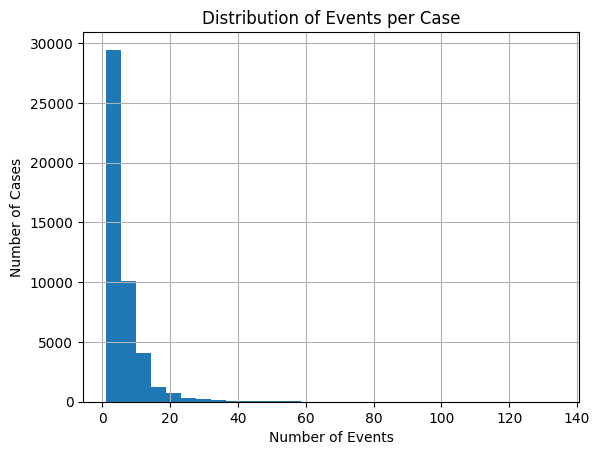

In [47]:
plt.figure()
case_df['num_events'].hist(bins=30)
plt.title('Distribution of Events per Case')
plt.xlabel('Number of Events')
plt.ylabel('Number of Cases')
plt.show()

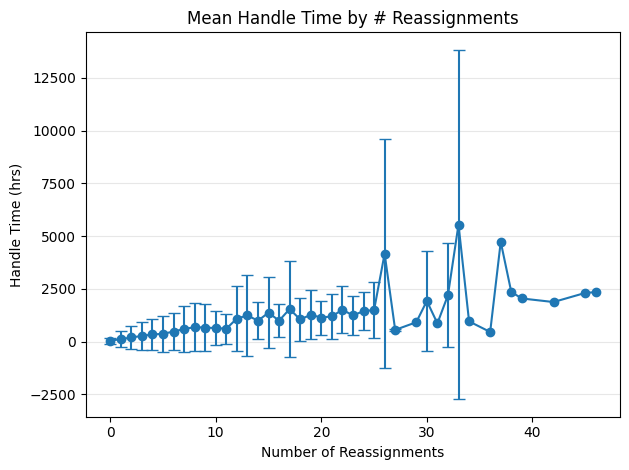

In [55]:

agg_all = (
    case_df
    .groupby('num_reassignments')['handle_time']
    .agg(['mean','std','count'])
    .sort_index()
)

plt.figure()
plt.errorbar(
    agg_all.index,
    agg_all['mean'],
    yerr=agg_all['std'],
    fmt='o-',
    capsize=4
)
plt.title('Mean Handle Time by # Reassignments')
plt.xlabel('Number of Reassignments')
plt.ylabel('Handle Time (hrs)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

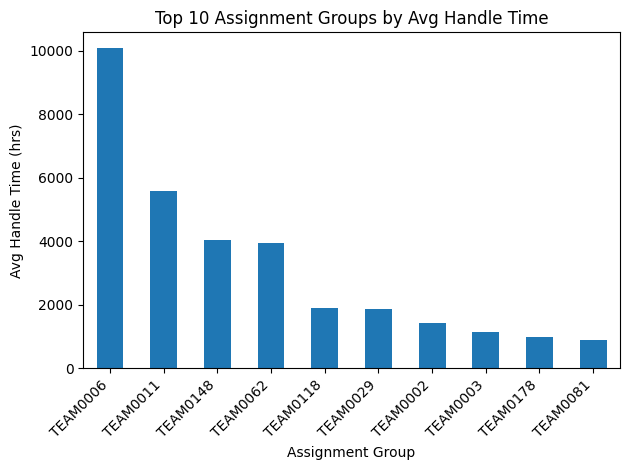

In [49]:
top10 = (
    case_df
    .groupby('assignment_group')['handle_time']
    .mean()
    .nlargest(10)
)

plt.figure()
top10.plot(kind='bar')
plt.title('Top 10 Assignment Groups by Avg Handle Time')
plt.xlabel('Assignment Group')
plt.ylabel('Avg Handle Time (hrs)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
#Convert the DataFrame into a PM4PY EventLog
log = log_converter.apply(
    data,
    variant=log_converter.Variants.TO_EVENT_LOG
)

In [26]:
import os
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.util import constants
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
import matplotlib.pyplot as plt

# — assume `data` is your pandas DataFrame and you’ve done:
# log = log_converter.apply(data, variant=log_converter.Variants.TO_EVENT_LOG)

# 1) set up the same parameter dict
pm_params = {
    constants.PARAMETER_CONSTANT_CASEID_KEY:   "case:concept:name",
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "concept:name",
    constants.PARAMETER_CONSTANT_TIMESTAMP_KEY:"time:timestamp"
}

# 2) discover the *frequency* DFG
dfg_freq, start_act, end_act = pm4py.discover_dfg(log, pm_params)

# 3) discover the *performance* DFG
#    we need the PERFORMANCE enum – we'll grab it through pm4py’s namespace
from pm4py.algo.discovery.dfg import algorithm as dfg_algo
dfg_perf, _, _ = pm4py.discover_dfg(log, pm_params, dfg_algo.Variants.PERFORMANCE)

# 4) view it (will annotate each A→B edge with average latency in seconds)
pm4py.view_dfg(dfg_perf, start_act, end_act, performance=True, max_num_edges=50)

# 5) pull out those avg latencies, convert to hours, and histogram them
perf_map = pm4py.get_performance_dfg(dfg_perf)  
latencies = [s / 3600.0 for s in perf_map.values()]

plt.figure(figsize=(6,3))
plt.hist(latencies, bins=30)
plt.title("Transition Latencies (hours)")
plt.xlabel("Hours between A → B")
plt.tight_layout()
plt.show()

# 6) build & evaluate an Inductive‐Miner model
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# mine and convert
im_tree = inductive_miner.apply(log, parameters=pm_params)
net, im, fm = pt_converter.apply(im_tree, variant=pt_converter.Variants.TO_PETRI_NET)

# fitness & precision
fit  = pm4py.fitness_token_based_replay(log, net, im, fm)["log_fitness"]
prec = pm4py.precision_token_based_replay(log, net, im, fm)
print(f"Token‐based fitness:   {fit:.3f}")
print(f"Token‐based precision: {prec:.3f}")

# view the Petri net
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


TypeError: unhashable type: 'dict'